In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torch.nn.utils import clip_grad_norm_
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
import numpy as np
import random
import copy
import os
import torch.optim as optim
from collections import Counter
from torchinfo import summary
from tqdm import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import time

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [50]:
train_transform = transforms.Compose([ 
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5,), (0.5,0.5,0.5)),  # 1 kanal normalize
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0)
])

In [51]:
dataset = datasets.ImageFolder(root=r"C:\Users\hdgn5\OneDrive\Masaüstü\PyTorch - CNN - Uygulamalar\Datasets\Multi-class Weather Dataset",transform=train_transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset ,test_dataset = random_split(dataset ,[train_size,test_size])

In [52]:
batch = 32
train_loader = DataLoader(train_dataset , batch_size = batch , shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch , shuffle=False)

In [53]:
for images , label in train_loader:
    print("Batch : " , images.shape )
    print("Label : " , label)
    break

Batch :  torch.Size([32, 3, 224, 224])
Label :  tensor([2, 0, 1, 2, 1, 2, 0, 1, 0, 3, 3, 0, 2, 3, 2, 1, 1, 0, 2, 3, 2, 3, 2, 3,
        0, 1, 2, 1, 3, 2, 3, 3])


In [54]:
labels_test = [label for _, label in test_dataset]
counts_txt = Counter(labels_test)

for idx, cls in enumerate(dataset.classes):  
    print(f"{cls} : {counts_txt[idx]} örnek")

Cloudy : 54 örnek
Rain : 38 örnek
Shine : 59 örnek
Sunrise : 74 örnek


In [55]:
class SeBlock(nn.Module):
    def __init__(self, channels , reduction = 4 ):
        super().__init__()
        self.fc1 = nn.Linear(channels,channels// reduction)
        self.fc2 = nn.Linear(channels // reduction,channels)

    def forward(self,x):
        b,c,_,_ = x.size()
        y = torch.mean(x,dim=(2,3))
        y = F.silu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b,c,1,1)
        return x * y 
class MiniBottleNeckSe(nn.Module):
    def __init__(self, in_channels, out_channels , stride=1,use_projection = False , p_drop =0.05):
        super().__init__()
        mid_channels = max(1,out_channels // 4)
        self.p_drop = p_drop

        self.layers = nn.ModuleList()
        chanells = [in_channels , mid_channels , mid_channels ,out_channels]
        kernel_sizes = [1,3,1]
        strides = [1,stride,1]

        for i in range(3):
            self.layers.append(nn.BatchNorm2d(chanells[i]))
            self.layers.append(nn.SiLU())
            self.layers.append(nn.Conv2d(chanells[i] , chanells[i+1] , kernel_size=kernel_sizes[i] , stride=strides[i] , padding= 1 if kernel_sizes[i] == 3 else 0))

        if use_projection or in_channels != out_channels or stride!=1:
            self.shortcut = nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride)
        else :
            self.shortcut = nn.Identity()
        
        self.se = SeBlock(out_channels,reduction=8)
    
    def forward(self,x):
        identity = self.shortcut(x)
        out = x

        for i in range(0,len(self.layers),3):
            out = self.layers[i](out)
            out = self.layers[i+1](out)
            out = self.layers[i+2](out)

        if self.training and torch.rand(1).item() < self.p_drop:
            out = identity
        
        out = self.se(out)
        out += identity
        return out
    
class MiniCNNSe(nn.Module):
    def __init__(self, input_channels = 3, num_classes = 4 , conv_channels =[64,128] , r_b = 1):
        super().__init__()

        self.conv_layers = nn.ModuleList()
        self.res_block = nn.ModuleList()
        in_ch = input_channels

        for out_ch in conv_channels:
            self.conv_layers.append(nn.Conv2d(in_ch,out_ch ,kernel_size=3 , stride=1 , padding=1))
            self.conv_layers.append(nn.BatchNorm2d(out_ch))

            for _ in range(r_b):
                stride_val = 2 if in_ch != out_ch else 1 
                use_prof = True if in_ch !=out_ch else False
                self.res_block.append(MiniBottleNeckSe(out_ch ,out_ch , stride=stride_val , use_projection=use_prof))
            
            in_ch = out_ch

        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(conv_channels[-1] ,  num_classes)
    
    def forward(self,x):
        res_idx = 0
        for i in range(0,len(self.conv_layers),2):
            x = F.silu(self.conv_layers[i+1](self.conv_layers[i](x)))
            x = F.dropout2d(x,p=0.1 , training=self.training)

            for _ in range(1):
                x = self.res_block[res_idx](x)
                res_idx += 1

        x = self.global_pool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x 

In [56]:
model = MiniCNNSe(input_channels=3, num_classes=4).to(device)

In [57]:
summary(model, input_size=(32,3,224,224), verbose=2)

Layer (type:depth-idx)                   Output Shape              Param #
MiniCNNSe                                [32, 4]                   --
├─ModuleList: 1-3                        --                        (recursive)
│    └─0.weight                                                    ├─1,728
│    └─0.bias                                                      ├─64
│    └─1.weight                                                    ├─64
│    └─1.bias                                                      ├─64
│    └─2.weight                                                    ├─73,728
│    └─2.bias                                                      ├─128
│    └─3.weight                                                    ├─128
│    └─3.bias                                                      └─128
│    └─Conv2d: 2-1                       [32, 64, 224, 224]        1,792
│    │    └─weight                                                 ├─1,728
│    │    └─bias                          

Layer (type:depth-idx)                   Output Shape              Param #
MiniCNNSe                                [32, 4]                   --
├─ModuleList: 1-3                        --                        (recursive)
│    └─0.weight                                                    ├─1,728
│    └─0.bias                                                      ├─64
│    └─1.weight                                                    ├─64
│    └─1.bias                                                      ├─64
│    └─2.weight                                                    ├─73,728
│    └─2.bias                                                      ├─128
│    └─3.weight                                                    ├─128
│    └─3.bias                                                      └─128
│    └─Conv2d: 2-1                       [32, 64, 224, 224]        1,792
│    │    └─weight                                                 ├─1,728
│    │    └─bias                          

In [58]:
loss_fonk = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters() , lr=0.001 , weight_decay=1e-4 , betas=(0.9,0.999) , eps=1e-7)
lr_scheduler = ReduceLROnPlateau(optimizer,mode="min" , patience=5,factor=0.3)

In [59]:
class EarlyStopping:
    def __init__(self, patience=7, delta=0, verbose=False, restore_best_weights=True):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.rest_best_weights = restore_best_weights
        self.best_loss = None
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            if self.rest_best_weights:
                self.best_model_wts = copy.deepcopy(model.state_dict())
        
        elif val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.rest_best_weights:
                self.best_model_wts = copy.deepcopy(model.state_dict())
            if self.verbose:
                print(f"Doğrulama kaybı iyileşti: {val_loss:.4f}. Modelin en iyi ağırlıkları kaydedildi.")
        else:
            self.counter += 1
            if self.verbose:
                print(f"Doğrulama kaybında iyileşme yok. Sayaç: {self.counter}/{self.patience}")
            
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Erken durdurma tetiklendi. Eğitim durduruldu.")

    def restore_weights(self, model):
        if self.rest_best_weights and self.best_model_wts is not None:
            model.load_state_dict(self.best_model_wts)

In [60]:
early_stopping = EarlyStopping(patience=7, verbose=True, restore_best_weights=True)

epochs_num = 10
best_val_loss = float('inf')
max_norm = 2

for epoch in range(epochs_num):
    start_time = time.time()
    model.train()
    train_loss = 0.0
    correct_train = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs_num}", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fonk(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()

        train_loss += loss.item()
        correct_train += (outputs.argmax(1) == labels).sum().item()

    train_loss /= len(train_loader)
    train_acc = 100 * correct_train / len(train_dataset)

    # EVAL
    model.eval()
    val_loss = 0
    correct_val = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fonk(outputs, labels)
            val_loss += loss.item()
            correct_val += (outputs.argmax(1) == labels).sum().item()

    val_loss /= len(test_loader)
    val_acc = 100 * correct_val / len(test_dataset)

    lr_scheduler.step(val_loss)

    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{epochs_num} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}% | "
          f"Time: {epoch_time:.1f}s | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")

    # EarlyStopping çağır
    early_stopping(val_loss, model)

     # Best model kaydet
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")

    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

early_stopping.restore_weights(model)

Epoch 1/10 | Train Loss: 0.9481, Train Acc: 66.44% | Val Loss: 0.9929, Val Acc: 56.00% | Time: 25.7s | LR: 0.001000


Epoch 2/10 | Train Loss: 0.8638, Train Acc: 72.00% | Val Loss: 0.8221, Val Acc: 75.11% | Time: 21.7s | LR: 0.001000
Doğrulama kaybı iyileşti: 0.8221. Modelin en iyi ağırlıkları kaydedildi.


Epoch 3/10 | Train Loss: 0.8457, Train Acc: 73.33% | Val Loss: 0.8372, Val Acc: 77.78% | Time: 21.9s | LR: 0.001000
Doğrulama kaybında iyileşme yok. Sayaç: 1/7


Epoch 4/10 | Train Loss: 0.8431, Train Acc: 73.56% | Val Loss: 0.8347, Val Acc: 74.67% | Time: 21.1s | LR: 0.001000
Doğrulama kaybında iyileşme yok. Sayaç: 2/7


Epoch 5/10 | Train Loss: 0.8575, Train Acc: 72.78% | Val Loss: 0.7932, Val Acc: 78.22% | Time: 20.5s | LR: 0.001000
Doğrulama kaybı iyileşti: 0.7932. Modelin en iyi ağırlıkları kaydedildi.


Epoch 6/10 | Train Loss: 0.8447, Train Acc: 71.44% | Val Loss: 0.7896, Val Acc: 74.67% | Time: 20.7s | LR: 0.001000
Doğrulama kaybı iyileşti: 0.7896. Modelin en iyi ağırlıkları kaydedildi.


Epoch 7/10 | Train Loss: 0.8359, Train Acc: 72.44% | Val Loss: 0.7919, Val Acc: 79.11% | Time: 21.9s | LR: 0.001000
Doğrulama kaybında iyileşme yok. Sayaç: 1/7


Epoch 8/10 | Train Loss: 0.7954, Train Acc: 74.67% | Val Loss: 0.8018, Val Acc: 79.11% | Time: 21.8s | LR: 0.001000
Doğrulama kaybında iyileşme yok. Sayaç: 2/7


Epoch 9/10 | Train Loss: 0.7943, Train Acc: 76.67% | Val Loss: 0.8013, Val Acc: 80.44% | Time: 21.6s | LR: 0.001000
Doğrulama kaybında iyileşme yok. Sayaç: 3/7


Epoch 10/10 | Train Loss: 0.8089, Train Acc: 74.33% | Val Loss: 0.7890, Val Acc: 80.89% | Time: 22.1s | LR: 0.001000
Doğrulama kaybı iyileşti: 0.7890. Modelin en iyi ağırlıkları kaydedildi.


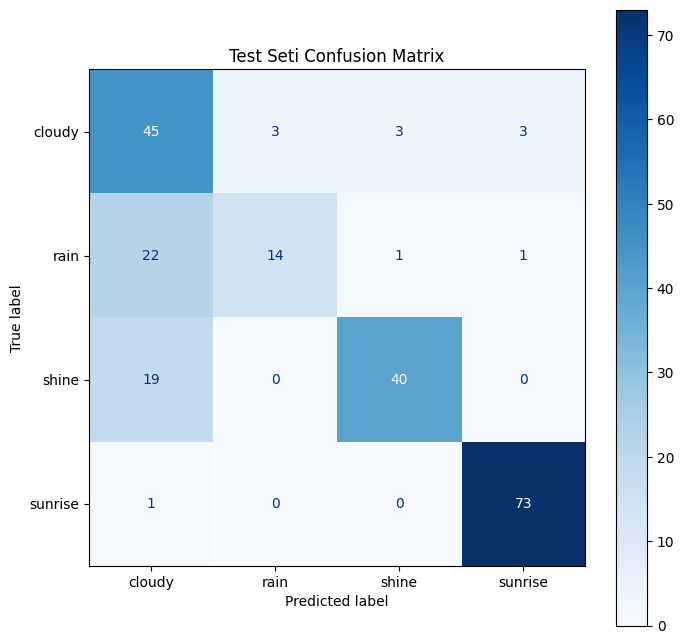

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

# Modeli eval moduna al
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix oluştur
cm = confusion_matrix(all_labels, all_preds)

# Sınıf isimlerini buraya yerleştiriyoruz
display_labels = ["cloudy", "rain", "shine", "sunrise"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

# CM'yi görselleştir
plt.figure(figsize=(8,8))
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.title("Test Seti Confusion Matrix")
plt.show()


In [66]:
from sklearn.metrics import classification_report
import torch

model.eval()

all_preds = []  
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Sınıf raporu
target_names = ["cloudy", "rain", "shine", "sunrise"]
report = classification_report(all_labels, all_preds, target_names=target_names)

print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

      cloudy       0.57      0.80      0.67        54
        rain       0.73      0.42      0.53        38
       shine       0.92      0.78      0.84        59
     sunrise       0.94      0.99      0.96        74

    accuracy                           0.79       225
   macro avg       0.79      0.75      0.75       225
weighted avg       0.81      0.79      0.79       225

